In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.constraints import max_norm
from keras import backend as K
from PIL import Image
import skimage

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.set_learning_phase(0) #set learning phase

#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"

base_model = load_model(path + 'models/' + 'Linenet_round_L2_epoch_4.h5')


#base_model = load_model(path + 'models/' + 'SEMNet_run2_epoch_4.h5')
#base_model_2 = load_model(path + 'models/' + 'EDGEnet2_round_L1_epoch_4.h5')

# model_2 = Model(inputs=base_model_2.input, \
#               outputs= base_model_2.get_layer('conv2d_1').output)
# model_2.summary()

In [3]:
# Make the model output 5 different layers
model = Model(inputs=base_model.input, \
              outputs= base_model.get_layer('conv2d_16').output)
#model.summary()

layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [5]:
sigma = 1.6
alpha = 0.5
Xi = 30
width = 20
space = 40
noise = 5
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

path = r"C:\\Users\\narendra\\Documents\\LER\\"
original_file = path + 'original_images2\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'


im = np.array(Image.open(original_file))
imnoisy = np.array(Image.open(noisy_file))


im = im/256
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)
impredict = model.predict(imnoisy)
impredict = impredict.reshape(1024,64,64)

imnoisy = imnoisy.reshape(1024,64)

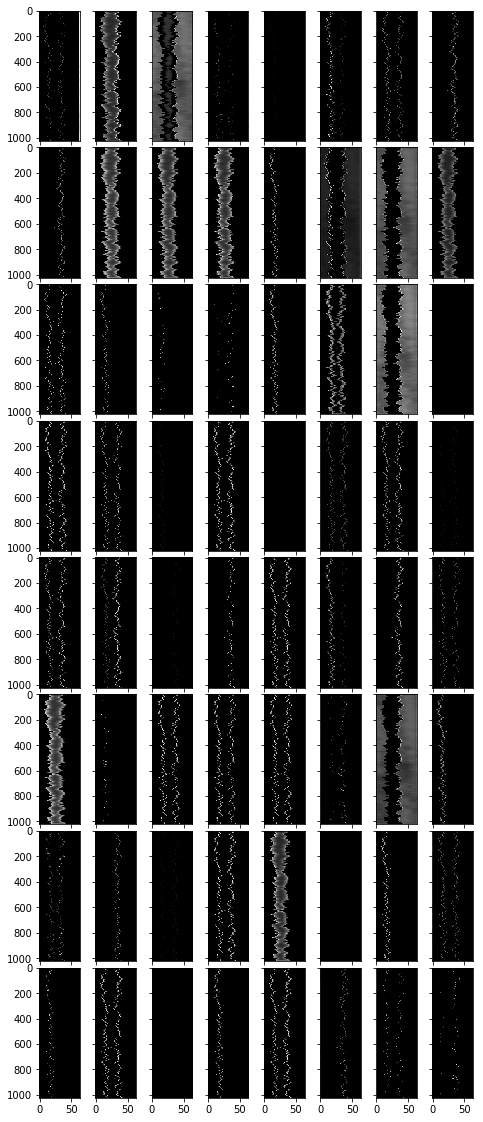

W shape :  (3, 3, 64)


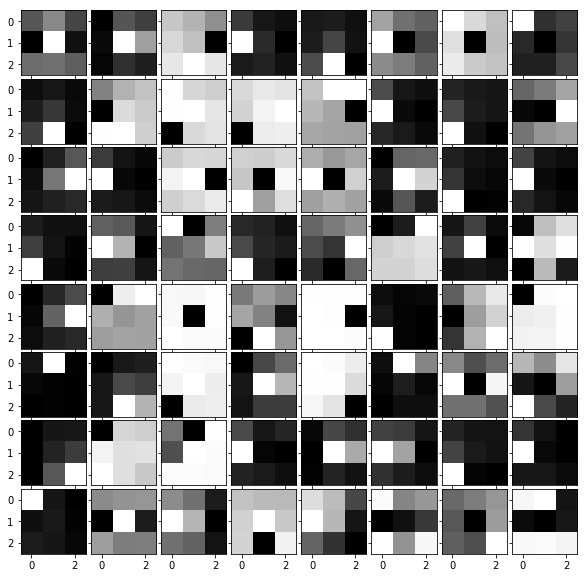

In [6]:
%matplotlib inline

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(8,20), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})
fig.subplots_adjust(wspace= 0.05, hspace=0.05)


for i in range(8):
    for j in range(8):
        m = impredict[:,:,i*8 +j].max()
        if m == 0:
            m = 1
        ax[i,j].imshow(impredict[:,:,i*8 +j]/m, cmap = 'gray',aspect= 0.2)

plt.savefig(path + 'Visualization\\LineNet1_images\\conv2d_16_output.png', dpi = 350)
plt.show()


# Visualize weights
W = model.layers[1].get_weights()[0][:,:,0,:]
print("W shape : ", W.shape)

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})
fig.subplots_adjust(wspace= 0.05, hspace=0.05)

for i in range(8):
    for j in range(8):
        ax[i,j].imshow(W[:,:,i*8 +j],cmap = 'gray')
plt.show()



In [7]:
# fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(10, 30), sharex=True,
#                        sharey=True, subplot_kw={'adjustable': 'box-forced'})
# fig.subplots_adjust(wspace= 0, hspace=0.05)
# for i in range(8):
#     for j in range(8):
#         ax[i,j].imshow(impredict_2[:,:,i*8 +j], vmin=0, vmax=2, cmap = 'gray',aspect= 0.2)
# plt.show()

# # Visualize weights
# W = model_2.layers[1].get_weights()[0][:,:,0,:]
# print("W shape : ", W.shape)

# fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), sharex=True,
#                        sharey=True, subplot_kw={'adjustable': 'box-forced'})
# fig.subplots_adjust(wspace= 0.05, hspace=0.05)


# for i in range(8):
#     for j in range(8):
#         ax[i,j].imshow(W[:,:,i*8 +j],cmap = 'gray')
# plt.show()

In [8]:
def gradient_ascent(layer_name, filter_index, step = 1, num_steps = 20):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, 1024, 64, 1))


    # run gradient ascent for 20 steps
    for i in range(num_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    return input_img_data

In [7]:
layer_name = 'conv2d_1'
#filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

img_data = np.zeros((64,1024,64,1))

for filter_index in range(64):
    img_data[filter_index] = gradient_ascent(layer_name, filter_index)
    

In [14]:
# from scipy.misc import imsave

# # util function to convert a tensor into a valid image
# def deprocess_image(x):
#     # normalize tensor: center on 0., ensure std is 0.1
#     x -= x.mean()
#     x /= (x.std() + 1e-5)
#     x *= 0.1

#     # clip to [0, 1]
#     x += 0.5
#     x = np.clip(x, 0, 1)

#     # convert to RGB array
#     x *= 255
#     #x = x.transpose((1, 2, 0))
#     x = np.clip(x, 0, 255).astype('uint8')
#     return x


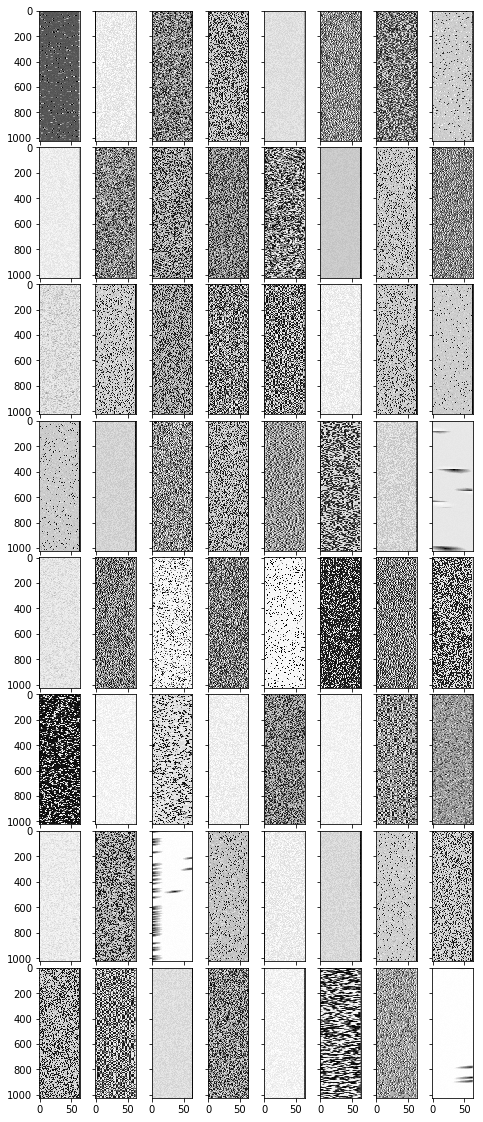

In [8]:
# img_data_scaled = np.zeros((64,1024,64))
# for i in range(64):
#     img_data_scaled[i,:,:] = deprocess_image(img_data[0,:,:,0])
    
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(8,20), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})
fig.subplots_adjust(wspace= 0.05, hspace=0.05)

for i in range(8):
    for j in range(8):
        ax[i,j].imshow(img_data[i*8 +j,:,:,0],cmap = 'gray', aspect = 0.2)

plt.savefig(path + 'Visualization\\LineNet1_images\\first_layer_max_image.png', dpi = 350)
plt.show()